In [1]:
import cv2
import matplotlib.pyplot as plt
from cv2.typing import *
import numpy as np
import matplotlib.patches as patches


def load_image(image_path: str):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def display_image(image: MatLike, title: str):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off the axis
    plt.show()


def quantize_image(image: MatLike, n_colors):
    Z = image.reshape((-1, 3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    final_image = res.reshape((image.shape))

    return final_image

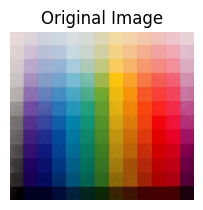

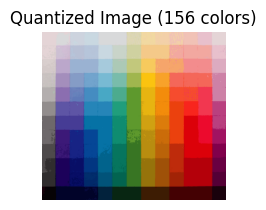

In [59]:
colors = 13*12
quantized_image = quantize_image(
    load_image(image_path="images/Ittens Colors.png"), colors)

plt.figure(1)
plt.subplot(223)
display_image(load_image(image_path="images/Ittens Colors.png"),
              'Original Image')

plt.figure(2)
plt.subplot(223)
display_image(quantized_image, f'Quantized Image ({colors} colors)')

In [2]:
def get_colors(image_array):
    colors = {}
    i = 0
    j = 0
    while i < image_array.shape[0]:
        while j < image_array.shape[1]:
            pixel = tuple(image_array[i, j])
            if pixel in colors:
                colors[pixel] = colors[pixel]+1
            else:
                colors[pixel] = 1
            j = j+1
        j = 0
        i = i+1
    return colors

In [3]:
def build_ittens_colors(image: MatLike):
    ittens_colors = {}
    i = 1
    j = 1
    cut = (int(image.shape[1]/12),  int(image.shape[0]/12))
    start_point = [0, cut[0]]
    while i < 13:
        ittens_colors[i] = []
        while j < 13:
            y = start_point[0]
            x = start_point[1]
            cropped_image = image[y:y+cut[0], x:x+cut[1]]
            colors = get_colors(quantize_image(cropped_image, 1)).keys()
            first_color = next(iter(colors), None)
            if first_color is not None:
                ittens_colors[i].append(first_color)
            start_point[0] = start_point[0] + cut[0]
            j += 1
        j = 1
        start_point[0] = 0
        start_point[1] = start_point[1] + cut[1]
        i += 1
    return ittens_colors

In [4]:
ittens_image = load_image("images/Ittens Colors.png")
ittens_colors = build_ittens_colors(ittens_image)
print(len(ittens_colors))

12


In [5]:
def get_color_value(ittens_colors: dict):
    for color in ittens_colors.keys():
        colors = ittens_colors.get(color)
        fig, ax = plt.subplots(1, 1, figsize=(10, 2))

        # Para cada color en la lista de colores
        for i, color in enumerate(colors):
            # Convertir el color de formato string a formato RGB
            rgb = color
            rgb = [c/255. for c in rgb]  # Normalizar a [0, 1]

            # Dibujar un rectángulo en el eje con el color correspondiente
            rect = patches.Rectangle((i, 0), 1, 1, facecolor=rgb)
            ax.add_patch(rect)

        # Configurar el eje
        ax.set_xlim(0, len(colors))
        ax.set_ylim(0, 1)
        ax.axis('off')  # Ocultar los ejes

        plt.show()

In [180]:
def show_color_palette(colors):
    c = np.array(colors)/255
    fig,ax = plt.subplots()
    for i,color in enumerate(c):
        rect = patches.Rectangle((i,0),1,0.2,facecolor=color)
        ax.add_patch(rect)
    ax.set_xlim(0,len(colors))
    ax.set_ylim(0,0.2)
    ax.axis("off")

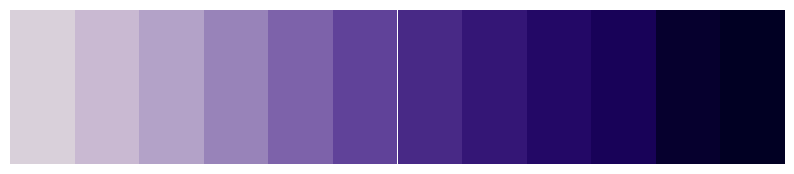

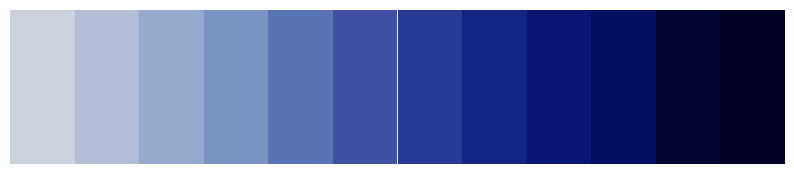

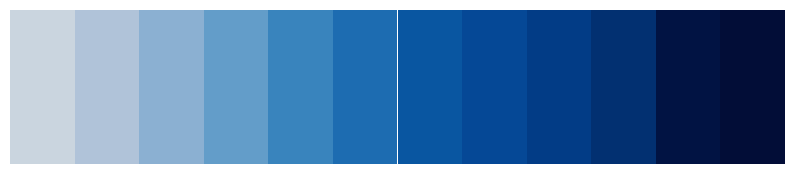

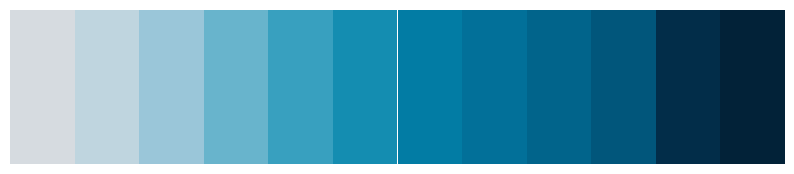

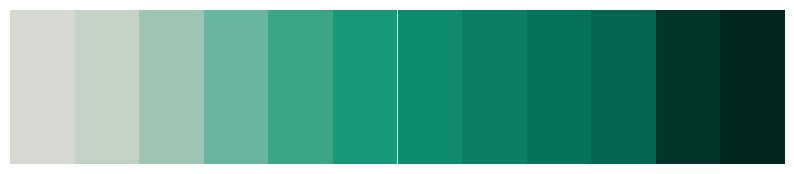

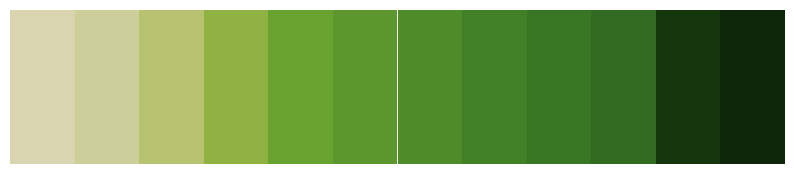

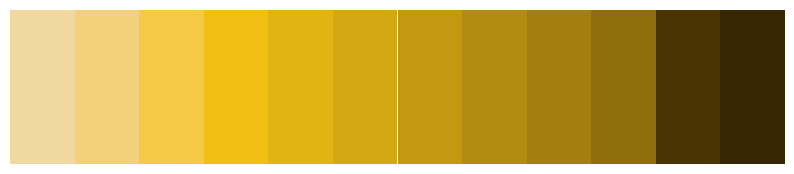

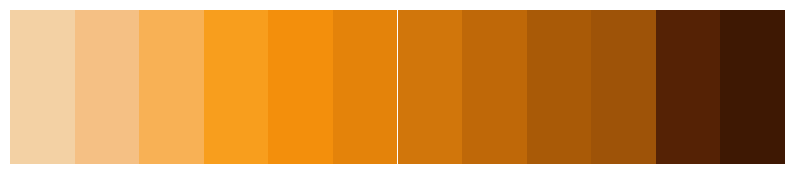

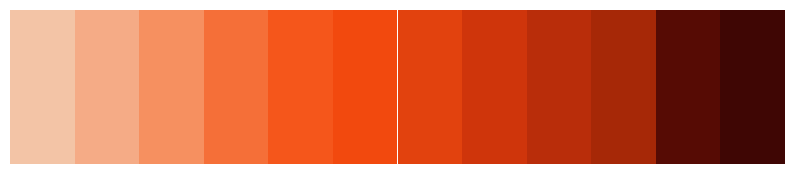

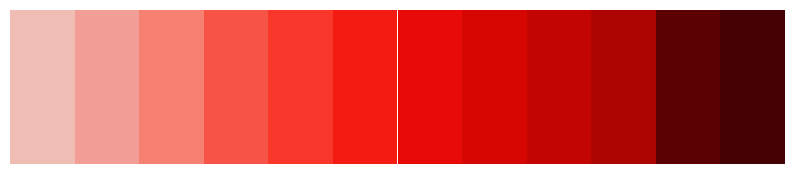

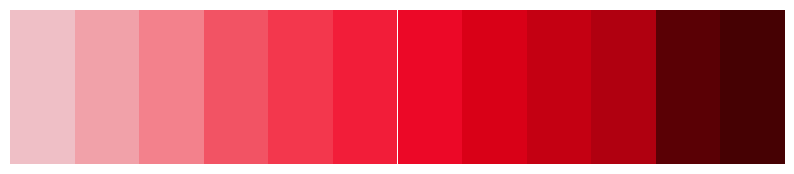

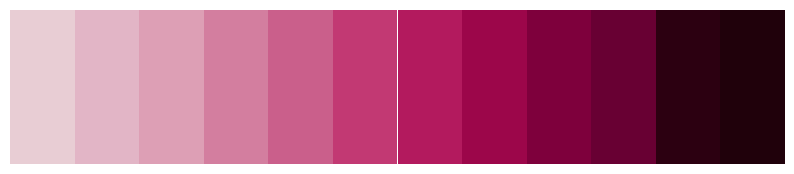

In [6]:
get_color_value(ittens_colors)

In [393]:
def color_distance(c1,c2):
    d = np.subtract(c1,c2)
    d = np.linalg.norm(d,axis=2)
    return d
def matrix_min_indexes(matrix):
    min_index = np.argmin(matrix)
    (i1,i2) = np.unravel_index(min_index,matrix.shape)
    return (i1+1,i2)
def angle_to_index(angle,list_length):
    return round(angle/360*list_length)
def rgb_to_hsv(rgb):
    to_convert = np.array([[rgb]],dtype=np.uint8)
    return cv2.cvtColor(to_convert,cv2.COLOR_RGB2HSV)[0][0]
def rgbs_to_hsv(rgbs):
    to_convert = np.array([rgbs],dtype=np.uint8)
    return cv2.cvtColor(to_convert,cv2.COLOR_RGB2HSV)[0]
def group_hues(colors, n):
    """
    Given some colors and N hues to separate into, returns a dictionary that maps each color
    to its group index
    --- 
    Inputs
        colors: A list of tuples, each containing a color in RGB values.
        n: The number of hue groups to separate into
    Returns
        color_mappings: A dictionary:
            key: Tuple with an RGB value
            value: Index of the color's corresponding group
        group_hues: A list that contains the hues of each group
    """
    
    hues = [rgb_to_hsv(c)[0] for c in colors]
    hues = np.float32(hues)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,labels,centers = cv2.kmeans(hues, n, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    group_hues = centers
    labels = labels.flatten()
    
    groups = [hues[labels==i] for i in range(n)]
    
    hue_mappings = {h:i for i,g in enumerate(groups) for h in g}
    color_mappings = {tuple(colors[i]):hue_mappings[hues[i]] for i in range(len(colors))}
    return color_mappings, group_hues
def find_closest_color(color,color_scheme:dict):
    """
    Given a color and a scheme, returns the index corresponding to the closest match in the color scheme
    ---
    Inputs
        color: The tuple of the RGB color to find the match for
        color_scheme: Dictionary with RGB values grouped by hues
    Returns
        index: A tuple with the 2 values needed to index the scheme for the matching color
    """
    matrix = [color_scheme[key] for key in sorted(color_scheme)]
    matrix = np.array(matrix)
    min_indices = [matrix_min_indexes(color_distance(c,matrix)) for c in color]
    return min_indices
def convert_im_palette(quantized_image,color_scheme):
    colors = get_colors(quantized_image)
    color_palette = list(colors.keys())
    indexes = find_closest_color(color_palette,ittens_colors)
    new_im = quantized_image.copy()

    for i,og in enumerate(color_palette):
        mask = cv2.inRange(quantized_image,np.array(og),np.array(og))
        ind = indexes[i]
        new_im[mask > 0] = color_scheme[ind[0]][ind[1]]
    return new_im

# Aplicación a un diseño de personaje

In [200]:
image = load_image("images/Slug.png")

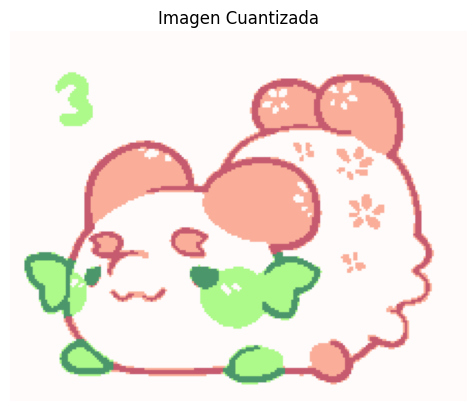

In [14]:
q_im = quantize_image(image,5)
display_image(q_im,"Imagen Cuantizada")

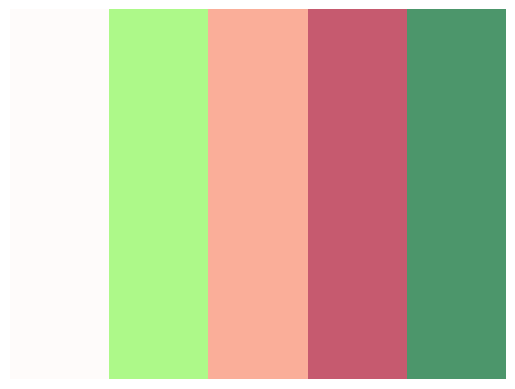

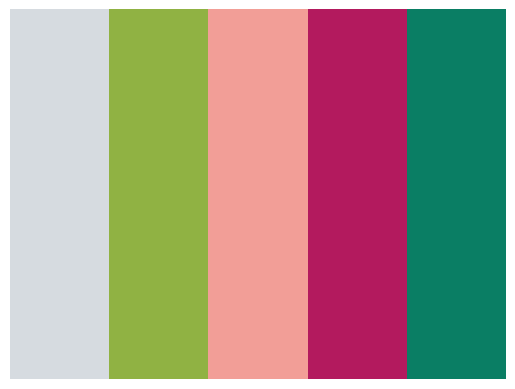

In [384]:
colors = get_colors(q_im)
color_palette = list(colors.keys())
show_color_palette(color_palette)
indexes = find_closest_color(color_palette,ittens_colors)
show_color_palette([ittens_colors[i][j] for i,j in indexes])

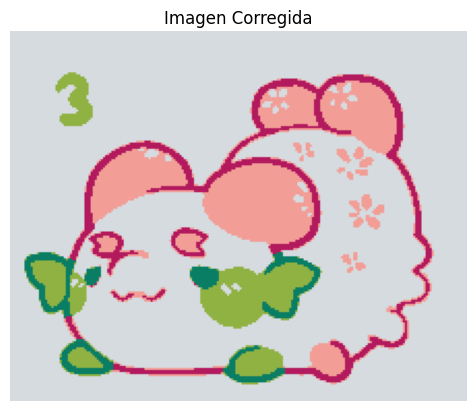

In [394]:
corrected = convert_im_palette(q_im,ittens_colors)
display_image(corrected,"Imagen Corregida")